# TTT4185 Machine learning for Speech technology

## Computer assigment 1: Speech analysis

This assignment assumes that the student has knowledge about short-time spectral estimation, linear prediction modeling and cepstral analysis. You should also know the concept of fundamental frequencies and formants.

Useful plotting commands from `matplotlib.pyplot`: `figure`, `plot`, `subplots`, `pcolormesh`

### Problem 1

In this problem we will look at a speech signal and do simple spectral analysis on the signal.

(a) Download the speech file `stry.wav` from Blackboard and load the file using `scipy.io.wavefile.read`. The speech represents the latter half of the English word "tapestry". The phonetic transcription is /s/ /t/ /r/ /iy/.
- Plot the signal.
- What is characteristic about the sounds /s/, /t/, /r/ and /iy/?
- Take a 40 millisecond subset of the vowel /iy/ and plot it.
- Find the fundamental frequency $f_0$ of the vowel.

16000


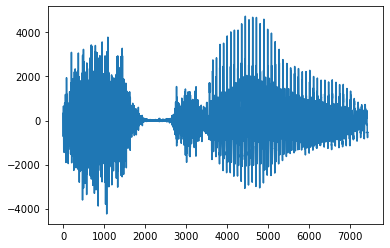

In [3]:
import scipy.io.wavfile
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import pysptk as pysptk
import sounddevice as sd
import soundfile as sf

filename = 'stry.wav'
data, fs = sf.read(filename, dtype='float32')  
sd.play(data, fs)
status = sd.wait() 

Fs, data = scipy.io.wavfile.read('stry.wav')
print(fs)
plt.plot(data)
plt.show()

/s/
Signal appears to be noisy
/t/
Almost no energy is observed
/r/
Has the most energy
/iy/
Longer and somewhat sustained pulse

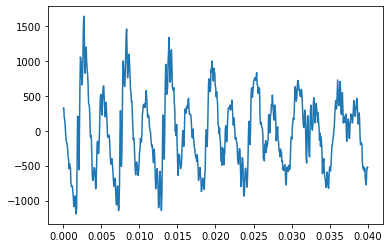

In [6]:
# 0.04 s of voewl /iy/
sample_iy = int(Fs*0.04)

data_iy = data[len(data) - sample_iy:]
time_iy = np.linspace(0,len(data_iy)/Fs,len(data_iy))
plt.plot(time_iy,data_iy)


Fundamental Frequency = Number of periods in sample / 'Sample time'
Fundamental Frequency = 7/0.04
Fundamental Frequency = 175 Hz

(b) Spectral analysis
- Estimate the spectrum of the vowel using an FFT of length 1024. Plot the spectrum expressed in dBs ($20 \log_{10}{x}$) as a function of frequency.
- Multiply the signal by a Hamming window and repeat the last operation.
- Explain the difference between the two spectra.
- Estimate the fundamental frequency $f_0$ using the spectrum, and compare the result to what you got in 1a)
- Roughly estimate the two first formant frequencies.

Useful Python functions: `numpy.fft.fft`, `numpy.abs`, `scipy.signal.hamming`.

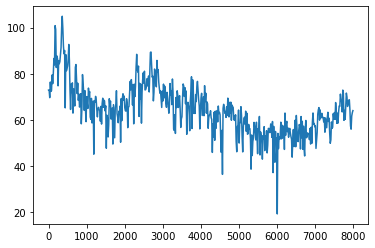

In [7]:
spectrum_FFT_iy = np.fft.fft(data_iy,n= 1024)
N = int(len(spectrum_FFT_iy)/2)
Freq_FFT = np.linspace(0,(Fs/2),N)
log_spectrum_FFT_iy = 20*np.log10(np.abs(spectrum_FFT_iy[:N]))
plt.plot(Freq_FFT,log_spectrum_FFT_iy)

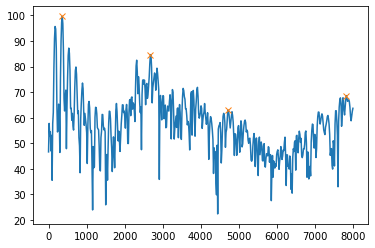

In [8]:
ham_window = signal.hamming(len(data_iy))
data_iy_hamming = ham_window * data_iy
FFT_data_iy_hamming = np.fft.fft(data_iy_hamming, 1024)
log_FFT_data_iy_hamming = 20*np.log10(np.abs(FFT_data_iy_hamming[:N]))
plt.plot(Freq_FFT,log_FFT_data_iy_hamming)
peaks, properties = signal.find_peaks (log_FFT_data_iy_hamming,distance = 120)
plt.plot(Freq_FFT[peaks[:4]],log_FFT_data_iy_hamming[peaks[:4]],"x")
plt.show()

No Hamming
Singal with some noise
Hamming
Finer representation of the signal - some noise is attenuated

By observation,
fo = Appx 250 Hz (quite large compared to that calculated from 1a)
f1 = Appx 350 Hz
f2 = Appx 2700 Hz



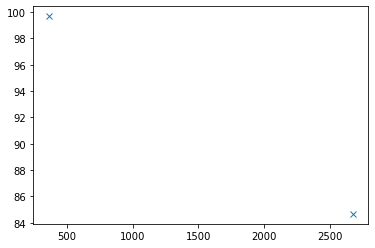

In [9]:
peaks, properties = signal.find_peaks (log_FFT_data_iy_hamming,distance = 120)
plt.plot(Freq_FFT[peaks[:2]],log_FFT_data_iy_hamming[peaks[:2]],"x")

(c) AR modeling
- Compute the coefficients of an AR model (linear prediction coefficients) with order 4, 8, 16 and 50, based on the vowel.
- Estimate the spectrum for each of the model orders. Plot the spectrum in dBs as a function of frequency.
- Compare your results with the spectrum from 1b). Which model order yields the "best" spectral envelope? What happens if the model order is too high or too low?
- Why is it not possible to estimate the fundamental frequency based on the LP model?

Useful Python functions: `pysptk.sptk.lpc`, `scipy.signal.freqz`. Check the documentation of the sptk package https://netix.dl.sourceforge.net/project/sp-tk to know which parameters are returned by the `lpc` function, and what model they correspond to.

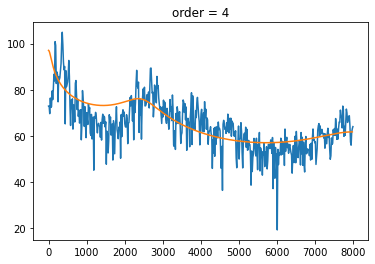

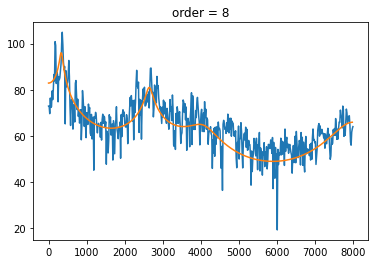

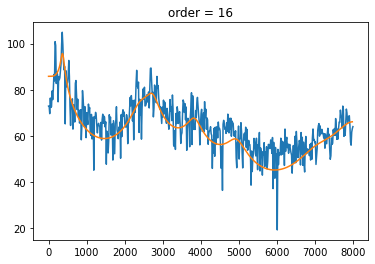

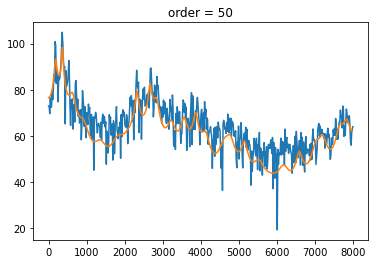

In [10]:
for i in [4,8,16,50]:
    coefficient_ar = pysptk.sptk.lpc(data_iy_hamming, i)
    w,h = signal.freqz(b= coefficient_ar[0],a=np.concatenate((np.array([1]),coefficient_ar[1:] )),fs=Fs)
    
    plt.title("order = "+str(i))
    plt.plot(Freq_FFT,log_spectrum_FFT_iy)
    plt.plot(w,20*np.log10(np.abs(h)))
    plt.show()

Order : 8 Yields the best spectral envelope

When the model is too low, formants are difficult to identify.
When the model is too high, it almost replicates the whole signal which is undesired



LP model aids in predicting gthe filter and not the signal. As such it is not possible to estimate the fundamental frequency.

(d) Use `scipy.signal.spectrogram` to create a spectrogram of the entire speech signal. Try to generate both wide- and narrow-band spectrograms by adjusting the window lengths and overlaps. Which characteristic traits of the speech sounds /s/, /t/, /r/ and /iy/ can you see from the spectrogram?

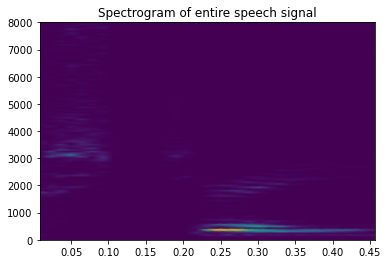

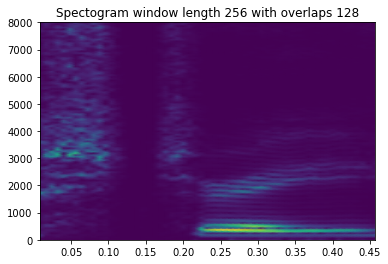

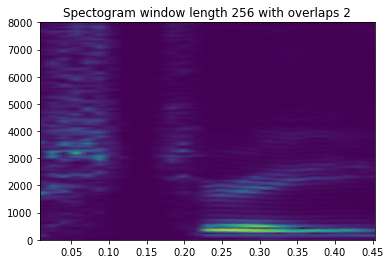

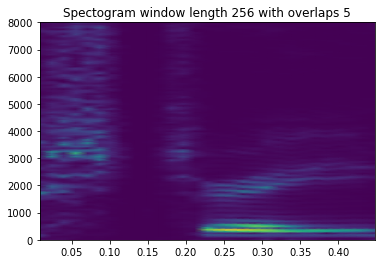

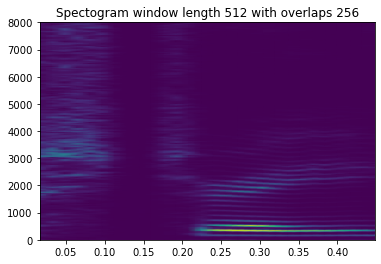

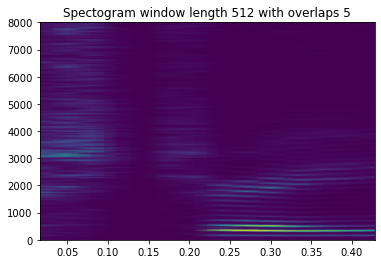

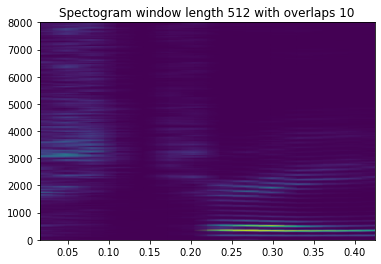

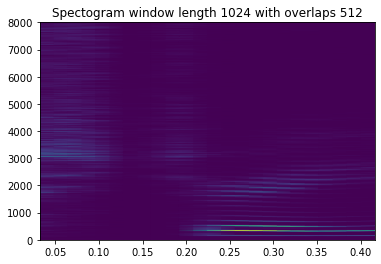

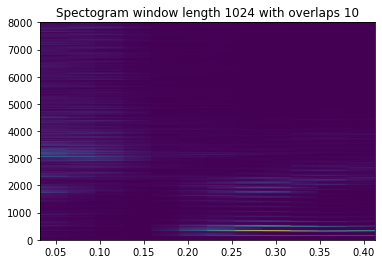

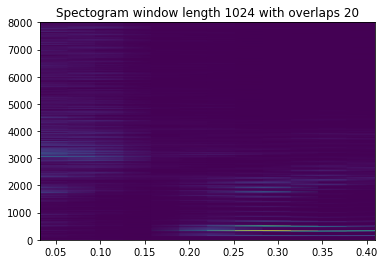

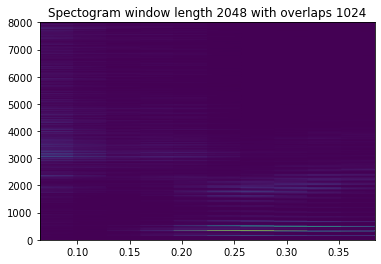

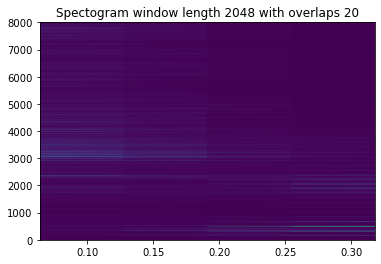

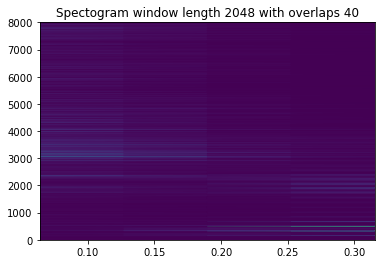

In [11]:
x= data
fs= Fs
f, t, Sxx = signal.spectrogram(x,fs)
plt.title('Spectrogram of entire speech signal')
plt.pcolormesh(t,f,Sxx, shading = 'gouraud')
plt.show()



for window_length in [256,512,1024,2048]:
    for overlap in (window_length//2, window_length//100,window_length//50):
        f, t, Sxx = signal.spectrogram(x,fs,window =signal.hamming(window_length),nperseg= window_length, scaling ='density', mode='magnitude', noverlap = overlap)
        plt.title(f'Spectogram window length {window_length} with overlaps {overlap}')
        plt.pcolormesh(t,f,Sxx, shading = 'gouraud')
        plt.show()

 Similar to the earlier wave generated in 1a, the spectogram shows the concentration of energy and where almost no energy is observed during the specified time frame
 
 /s/ 
 so many frequencies observed with energy concentration at about 3,000 to 3,200 Hz
 /t/ 
 as can be seen, from time 0.10 to 0.15 no energy is observed during to the t sound
 /r/ 
 Most dense energy concentration observed at time 0.23 to appx 0.25
 /iy/
 Has some energy but fades

### Problem 2
In this problem we look at the cepstrum and deconvolution

(a) Compute and plot the real cepstrum of the vowel from problem 1a).

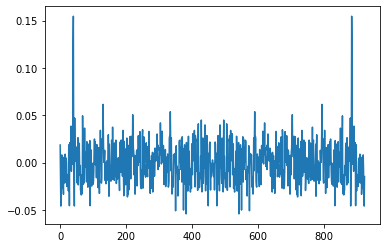

In [14]:
cepstrum = np.fft.ifft(np.log(np.abs(spectrum_FFT_iy)))
real_cepstrum = np.real(cepstrum)

plt.plot(real_cepstrum[50:-50])
plt.show()

(b) Use the cepstrum to compute the fundamental frequency $f_0$. Compare your results with those obtained in problem 1).

In [15]:
real_cepstrum=real_cepstrum[:N]
fo = Fs/np.argmax(real_cepstrum[10:])
print(f'fo is {fo} Hz')

fo is 200.0 Hz


Compared to the fundamental frequency in 1 This appears to be the most accurate.

(c) In this subproblem you will use the cepstrum to estimate the spectral envelope
- Use liftering to extract the part of the ceptrum that represents the spectral envelope.
- Plot the spectral envelope as a function of frequency, and compare the result with the results from problem 1).

Hint 1: Remember that the cepstrum of a real signal is symmetric, so the liftered signal mus be symmetric as well.

Hint 2: The FFT of a real, symmtric signal is real, but due to round-off errors small imaginary noise may occur. Use `np.real` to get to the real part of the liftered log-spectrum.

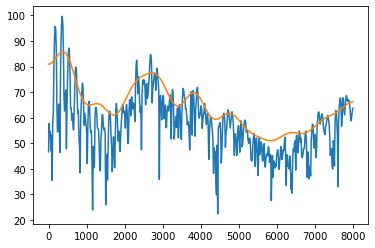

In [20]:
cepstrum_envelope = np.real(cepstrum)
cepstrum_envelope[20:len(cepstrum_envelope)-20] = 0
spectral_envelope = np.abs(np.exp(np.fft.fft(cepstrum_envelope, n= 1024)))
plt.plot(Freq_FFT, 20*np.log10(np.abs(FFT_data_iy_hamming[:N])))
plt.plot(Freq_FFT, 20*np.log10(spectral_envelope[:N]))